# Comma.ai Data Visualisation and Exploration

Licence: Creative Commons Attribution-NonCommercial-ShareAlike 3.0 License

In [480]:
import h5py
import numpy as np
import pandas as pd
import random
import math

# Visual 
import cv2
import matplotlib.patches as patches
from IPython import display
from IPython.display import HTML
from pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

# Imports for Keras models
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, Dropout
from keras.models import model_from_json

# Imports for batch generator
from keras.utils import Sequence
from keras.preprocessing import image
from keras.utils import np_utils

import warnings
warnings.filterwarnings("ignore")

In [528]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

## I - Load Comma.ai Dataset

### Load Images - adquired at 20Hz

In [499]:
# Loading images from h5 file
filename = 'comma-dataset/camera/2016-01-30--11-24-51.h5'
camera = h5py.File(filename,'r')

# Get keys 
for field in camera.keys():
    print(field)

imgs = camera.get('X')
imgs = np.array(imgs)

print('Loaded images = ', imgs.shape[0])
print('Image shape = ', np.shape(imgs)[1:])

X
Loaded images =  52722
Image shape =  (3, 160, 320)


### Load CAN Logs - Keeping only relevant keys  (adquired at 100Hz)

In [5]:
# Loading logs
filename = 'comma-dataset/log/2016-01-30--11-24-51.h5'
logs = h5py.File(filename,'r')

# Get keys 
#for field in logs.keys():
#    print(field)

# Loading car measures @ 100Hz
steering_angle = np.array(logs.get('steering_angle')).reshape(-1,1)
speed = np.array(logs.get('speed')).reshape(-1,1)
accel = np.array(logs.get('car_accel')).reshape(-1,1)
brake = np.array(logs.get('brake')).reshape(-1,1)
stopped_flag = np.array(logs.get('standstill')).reshape(-1,1)

# Camera index reference
cam_index = np.array(logs.get('cam1_ptr')).reshape(-1,1)

# Radar and lidar measures
UN_T_radar_msg = np.array(logs.get('UN_T_radar_msg')).reshape(-1,1)
velodyne_heading = np.array(logs.get('velodyne_heading')).reshape(-1,1)
velodyne_imu = np.array(logs.get('velodyne_imu')).reshape(-1,1)
velodyne_gps = np.array(logs.get('velodyne_gps')).reshape(-1,1)

# Stack Can data
can_data = np.concatenate((cam_index, steering_angle, speed, accel, brake, stopped_flag ), axis=1)
print(np.shape(can_data))

# Convert to Pandas dataframe
var_names = 'cam_index steering_angle speed accel brake stop_flag'.split() # radar vel_heading vel_imu vel_gps'
CAN_df = pd.DataFrame(can_data, columns=var_names)
CAN_df.head()

# Sensor data do not have the same shape
#np.shape(np.array(UN_T_radar_msg))
#np.shape(np.array(velodyne_gps))
#np.shape(np.array(velodyne_heading))
#np.shape(np.array(velodyne_imu))

(263583, 6)


cam_index  steering_angle  speed  accel    brake  stop_flag
0        0.0            80.0    0.0    0.0  63872.0        0.0
1        0.0            80.0    0.0    0.0  63872.0        0.0
2        0.0            80.0    0.0    0.0  63872.0        0.0
3        0.0            80.0    0.0    0.0  63872.0        0.0
4        0.0            80.0    0.0    0.0  63872.0        0.0

In [6]:
CAN_df.describe()

cam_index  steering_angle          speed          accel  \
count  263583.000000   263583.000000  263583.000000  263583.000000   
mean    26356.901450       22.495368      18.469584      -0.006569   
std     15222.186645      605.378073      12.709778       0.712962   
min         0.000000    -5121.000000      -1.832309      -4.596708   
25%     13174.000000      -13.000000       4.734308      -0.268545   
50%     26356.000000        2.000000      25.933573       0.000000   
75%     39540.000000       18.584913      30.029360       0.226096   
max     52721.000000     5011.000000      35.879706       5.121176   

               brake      stop_flag  
count  263583.000000  263583.000000  
mean      236.890389       0.855256  
std      1990.971916       0.351843  
min       -64.000000       0.000000  
25%         0.000000       1.000000  
50%         0.000000       1.000000  
75%       128.000000       1.000000  
max     63872.000000       1.000000

<strong> Notes: </strong> 
    - 3.4h of recordings.
    - Steering angle maximum value = 5011 degrees, minimum = - 5121. 
    - Average speed 18.5 MPH.
    - Average accel -0.00659G.

## II - Data Visualization

### Random examples Visualization
<strong> Note: </strong> Images are stored in 'channel_first' mode taken at 20Hz.

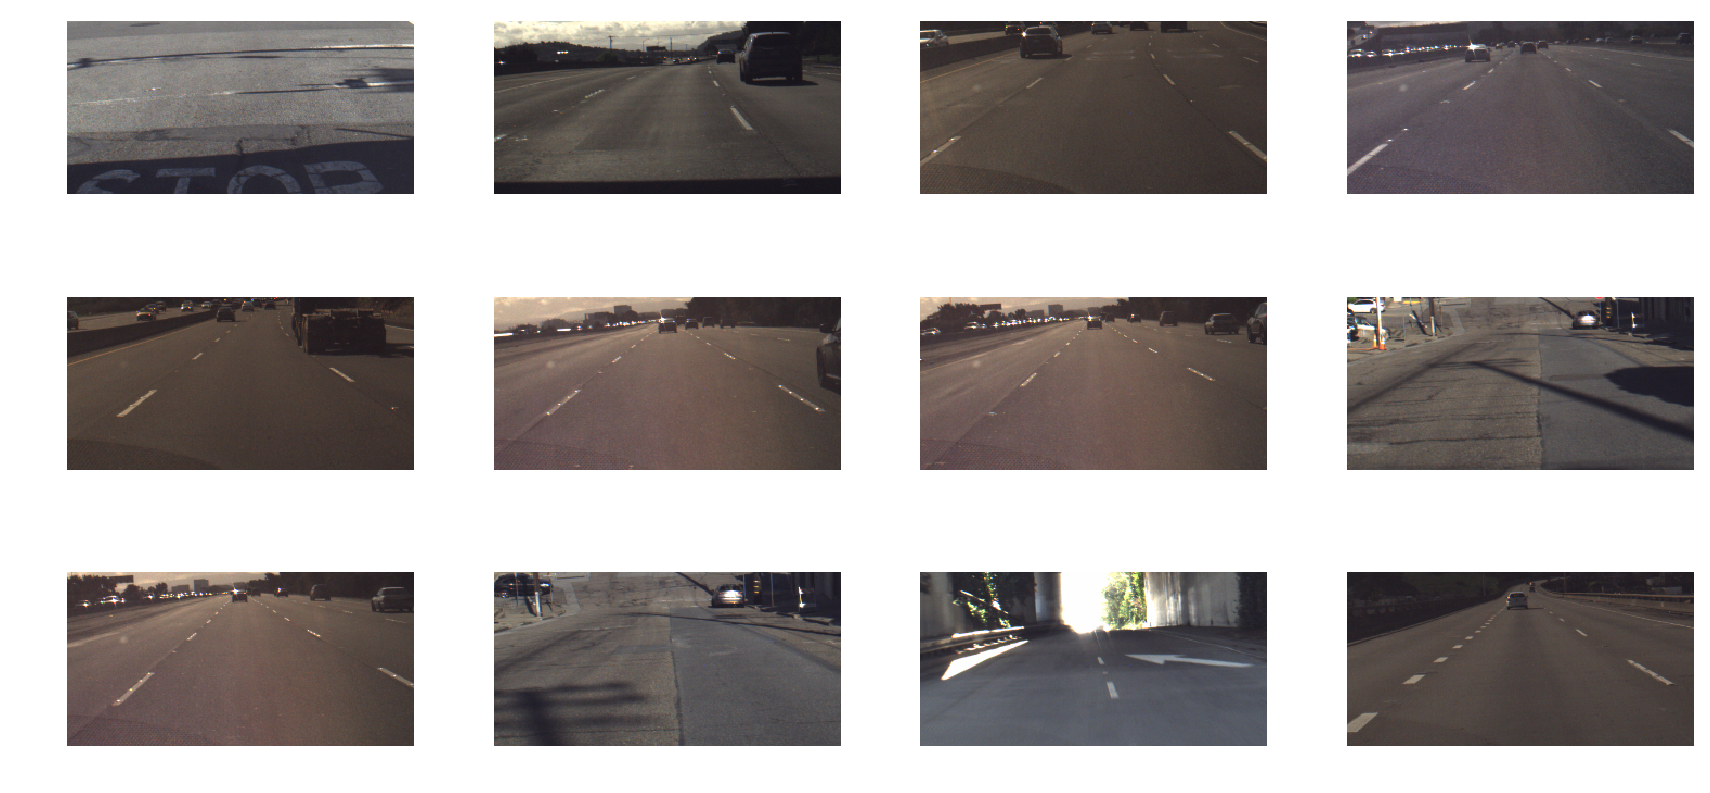

In [154]:
def channel_last(img):
    '''Convert 'channel_first' to 'channel_last' format.
    
    '''
    return np.rollaxis(img, 0, 3)  

plt.figure(0, figsize=(12,6))
for i in range(1, 13):
    plt.subplot(3,4,i)
    random_int = int(random.randint(0,16000))
    plt.imshow(channel_last(imgs[random_int]))
    plt.axis('off')
plt.tight_layout()

### Plot CAN Logs distribution

Text(0.5,1,'Steering angle Histogram')

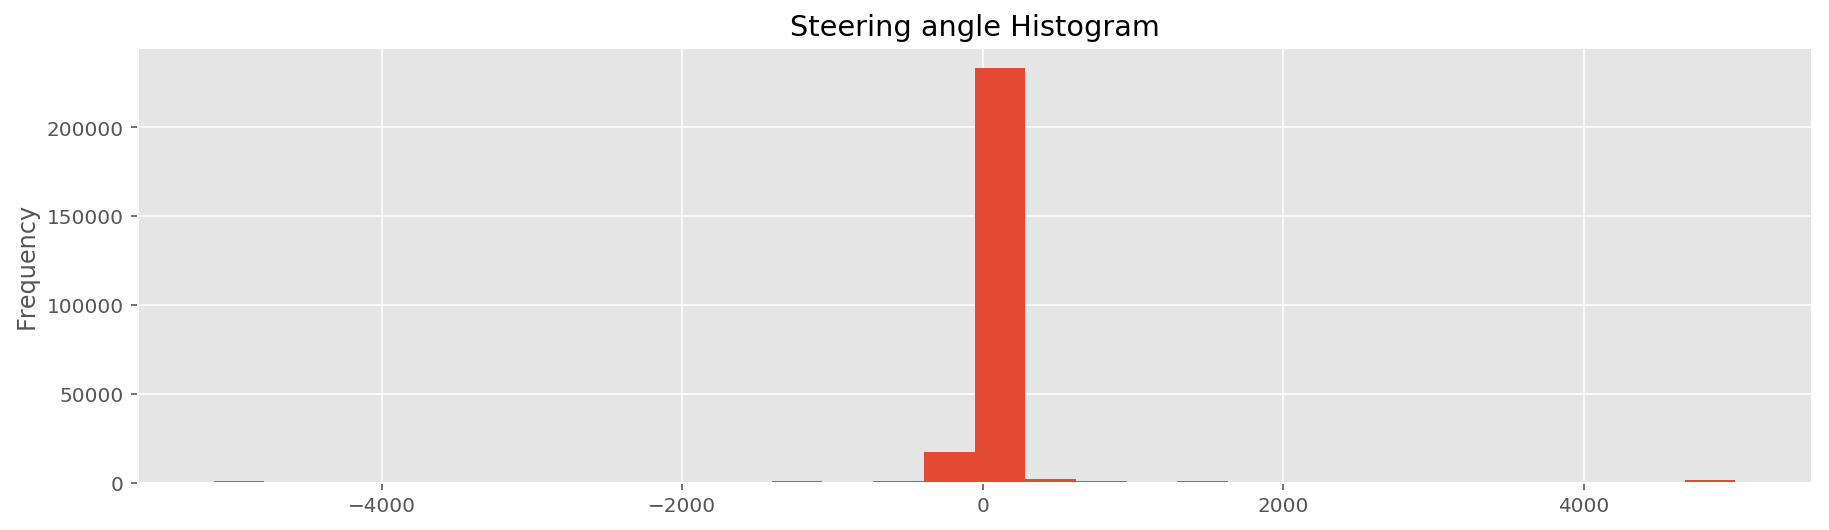

In [156]:
CAN_df['steering_angle'].plot.hist(bins=30)
plt.title('Steering angle Histogram')

<strong>Note:</strong> Very high value angles correspond to heavy turns during parking, city roads, etc.

Text(0.5,1,'Acceleration Histogram')

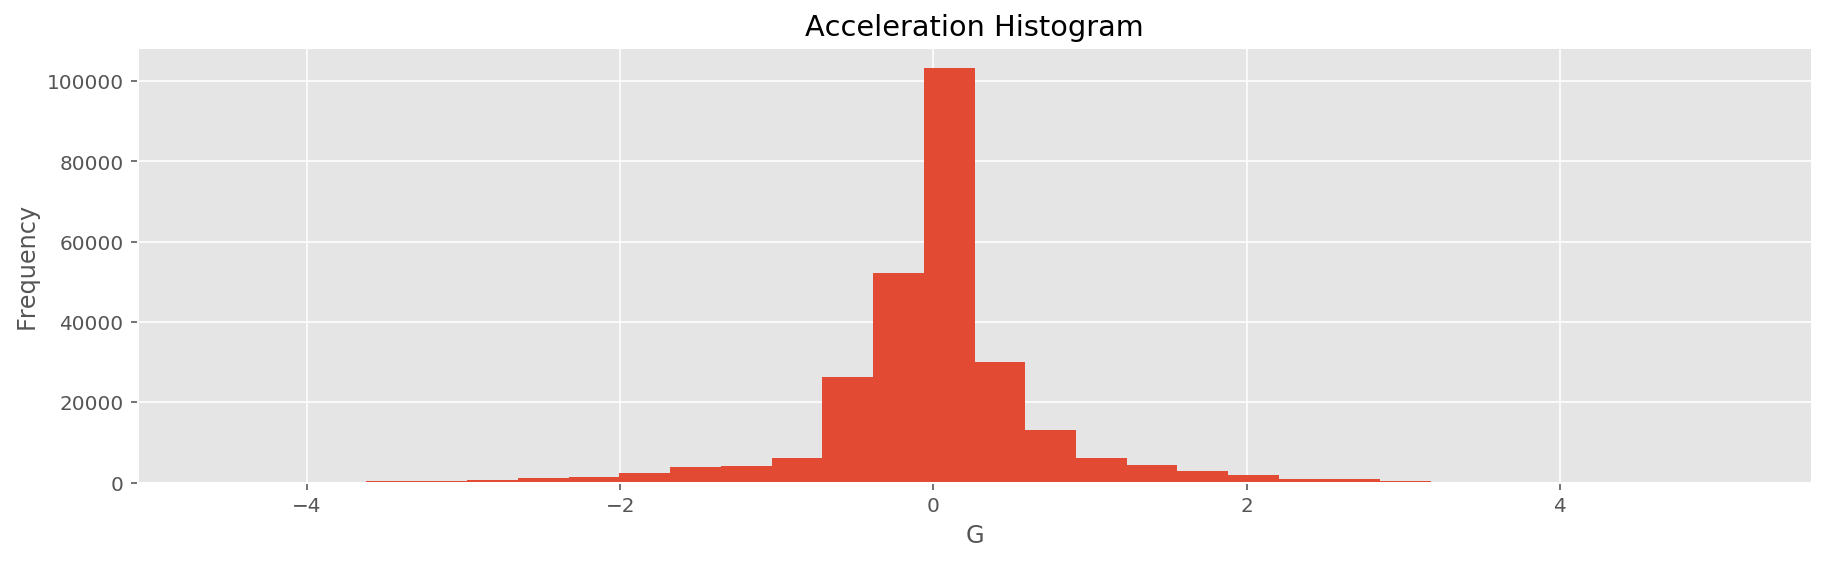

In [158]:
CAN_df['accel'].plot.hist(bins=30)
plt.xlabel('G')
plt.title('Acceleration Histogram')

Text(0.5,1,'Stop flag Histogram')

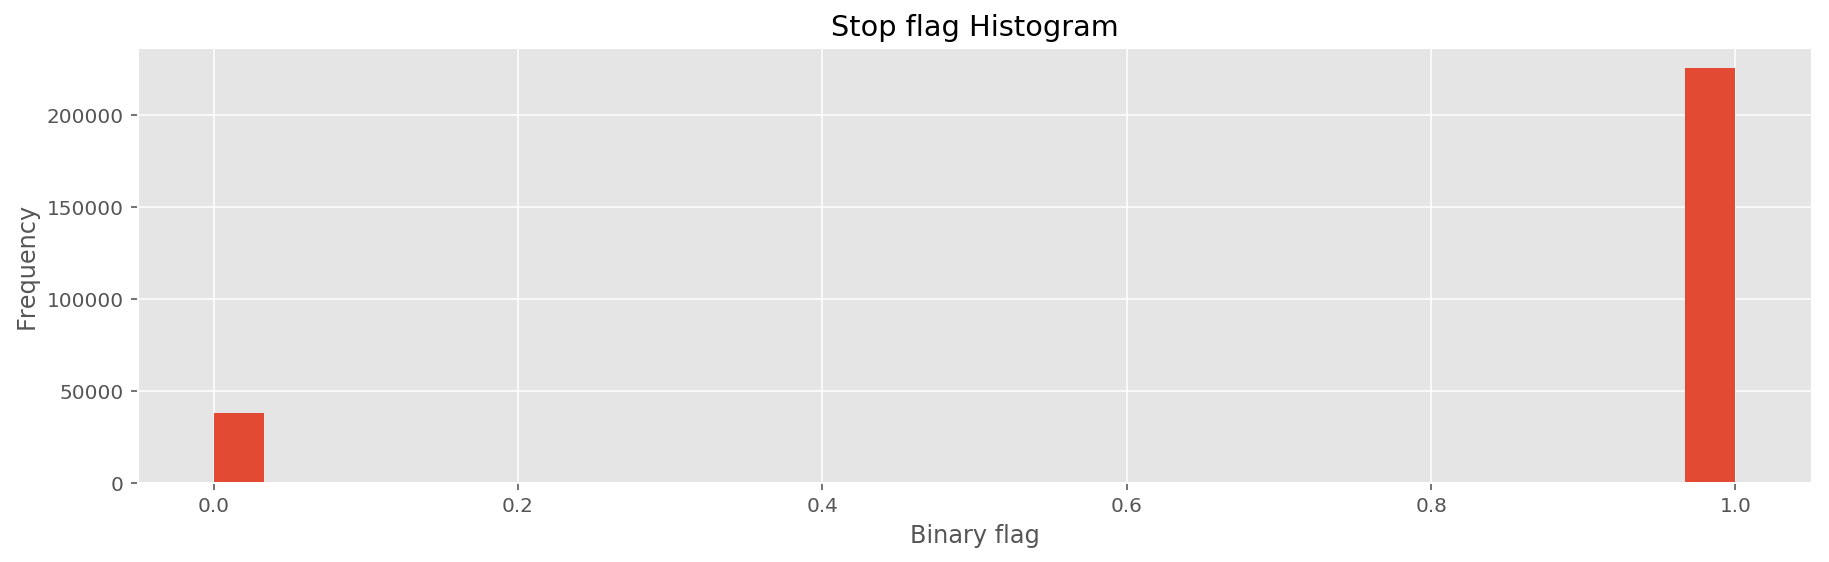

In [159]:
CAN_df['stop_flag'].plot.hist(bins=30)
plt.xlabel('Binary flag')
plt.title('Stop flag Histogram')

(0, 3500)

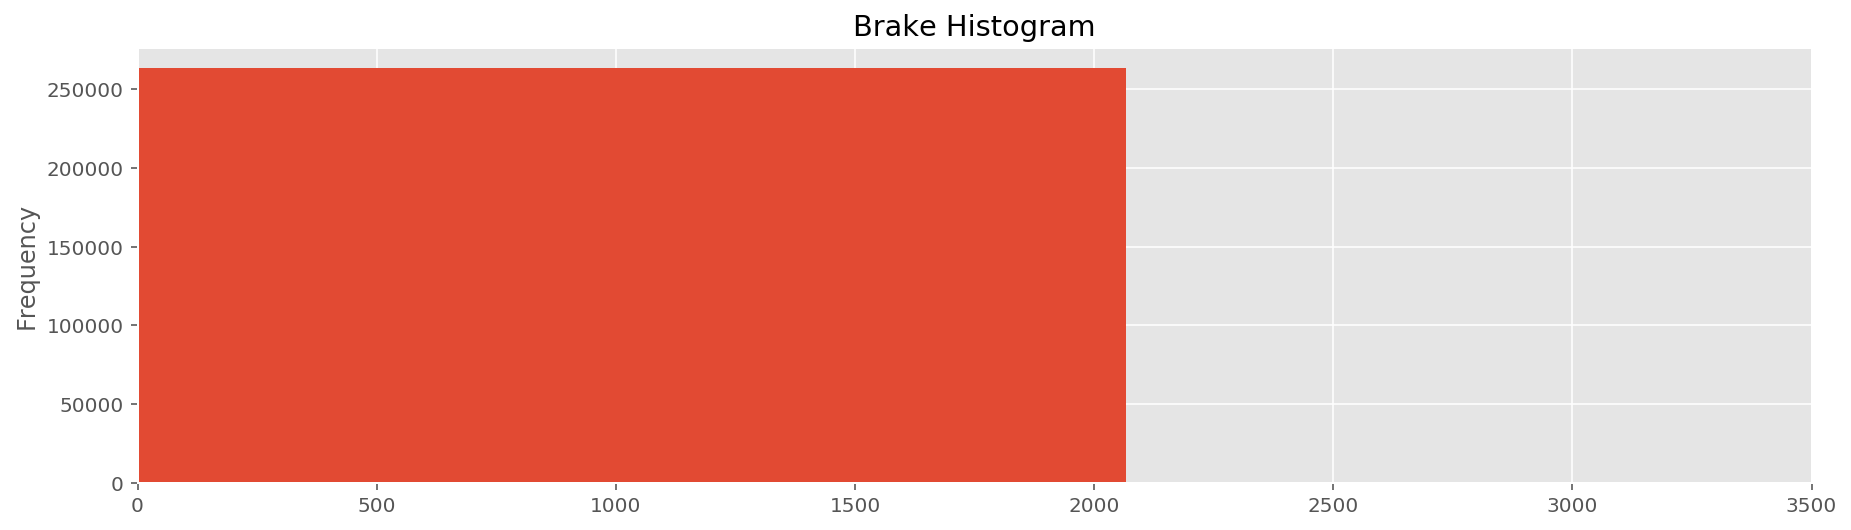

In [160]:
CAN_df['brake'].plot.hist(bins=30)
plt.title('Brake Histogram')
plt.xlim([0,3500])

<strong>Note:</strong> Brake data is uniformelly distributed.

## Video simulator with CAN annotations

In [168]:
def annotate(img, dataframe_row, opacity=0.6):

    meta = dataframe_row['steering_angle speed accel brake'.split()]
    
    frame_can = 'st_angle={} speed={}MPH accel={}G brake={}'.format(meta[0].round(2), 
                                                                      meta[1].round(2), 
                                                                      meta[2].round(2),
                                                                      meta[3].round(2))
    frame = img.copy()
    overlay = frame.copy()

    font = cv2.FONT_HERSHEY_SIMPLEX
    y0, dy = 15, 10
    for i, line in enumerate(frame_can.split()):
        y = y0 + i*dy
        cv2.putText(overlay, line, (10, y), font, 0.3, (255, 255, 255), 1)

    #cv2.circle(overlay, (133, 132), 12, (0, 255, 0), -1)
    cv2.addWeighted(overlay, opacity, frame, 1 - opacity, 0, frame)
    
    return frame


def simulator(model,data,images_path,f_init=230,f_end=300):
    """Plot images and autopilot model prediction.
    
    model: Pre-trained Keras model
    data: CAN_dataframe
    f_init: initial frame
    f_end: end frame
    """
    fig, ax = plt.subplots(1)
    plt.title('Model predictions')
    for i in range(f_init,f_end,3):
        image_id = data['img'].iloc[i]
        img = im.imread(os.path.join(images_path, image_id))
        angle_rad = float(model.predict(img.reshape(1,120,160,3)))
        angle = (180*angle_rad/3.1416)
        error = angle - (data['angle'].iloc[i]*180/3.1416)
        left = angle_rad + 60
        rect = patches.Rectangle((left, 85),40,20, angle=angle,
                                 linewidth=4,edgecolor='lightgreen',facecolor='none',
                                 label='{:2f} degrees. Error {:2f}'.format(angle,error)
                                 )
        patch = ax.add_patch(rect)
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.imshow(img)
        plt.legend()
        plt.axis('off')
       # time.sleep(0.1)
        patch.remove()
    plt.close()
    

def play_raw_data(data_frame, imgs, f_init=0, f_end=300):
    """Plat sucession of frames from input data.
    
    data: CAN_dataframe
    f_init: initial frame
    f_end: end frame
    """
    fig, ax = plt.subplots(1)
    for i in range(f_init,f_end,3):
        image_id = data_frame['cam_index'].iloc[i]
        img = imgs[int(image_id)]
        img = annotate(channel_last(img), data_frame.iloc[i], opacity=0.6)
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.imshow(img)
        plt.axis('off')
    plt.close()
    
def annotated_plot(data_frame, imgs):
    """Plat sucession of frames from input data.
    
    data: CAN_dataframe
    """
    image_id = data_frame['cam_index'].iloc[i]
    #img = imgs[int(image_id)]
    img = annotate(channel_last(img), data_frame.iloc[i], opacity=0.6)
    plt.imshow(img)
    plt.axis('off')


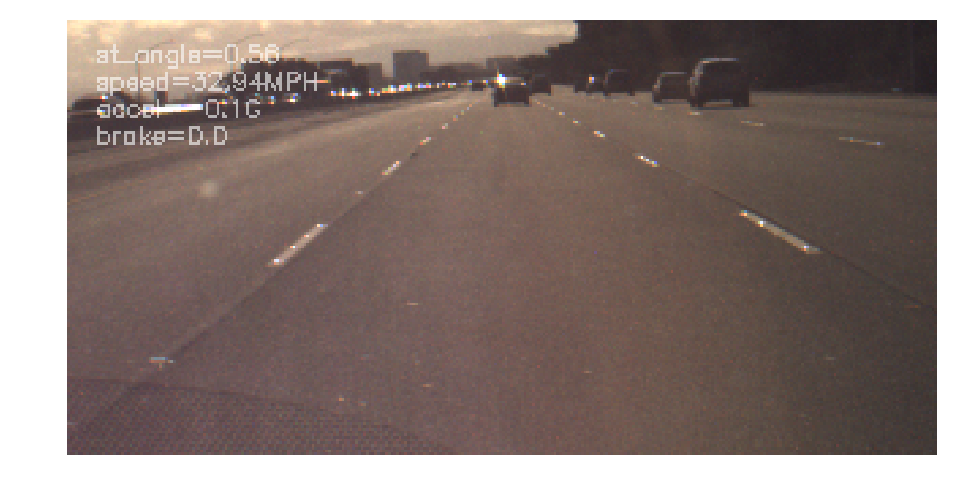

In [161]:
# Set bigger figure size
#rcParams['figure.figsize'] = 15, 4
play_raw_data(CAN_df, imgs, f_init=45000,f_end=45300)

## III) Data Preprocessing
    1) Camera and logs downsampling to 10Hz.
    2) Select sequences where the car was between the lanes.
    3) Perform data augmentation by adding abnormal driving condition.
    4) Get estimation of per-channel-means to perform VGG-like image normalization.
    5) Equilibrate the dataset to avoid biases.
    6) Normalize target variable.
    
### Data Downsampling

Donwsampling to 10Hz allow to avoid unnecesary computation on very similar frames.

In [10]:
# Downsampling using standard Python Syntax
CAN_downsampled = CAN_df.iloc[::10, :]
CAN_downsampled.describe()

cam_index  steering_angle         speed         accel         brake  \
count  26359.000000    26359.000000  26359.000000  26359.000000  26359.000000   
mean   26355.291362       22.496507     18.469126     -0.006211    237.197412   
std    15222.833753      605.387058     12.710239      0.712639   1993.878549   
min        0.000000    -5121.000000     -1.798662     -4.571521    -64.000000   
25%    13173.000000      -13.000000      4.731583     -0.265959      0.000000   
50%    26355.000000        2.000000     25.932086      0.000000      0.000000   
75%    39538.000000       18.783206     30.028582      0.221794    130.192964   
max    52720.000000     5010.911211     35.829370      4.969861  63872.000000   

          stop_flag  
count  26359.000000  
mean       0.855040  
std        0.352067  
min        0.000000  
25%        1.000000  
50%        1.000000  
75%        1.000000  
max        1.000000

### Extract Relevant Sequences

Retain sequences where the car is between lanes.

Text(0.5,1,'Steering Angle')

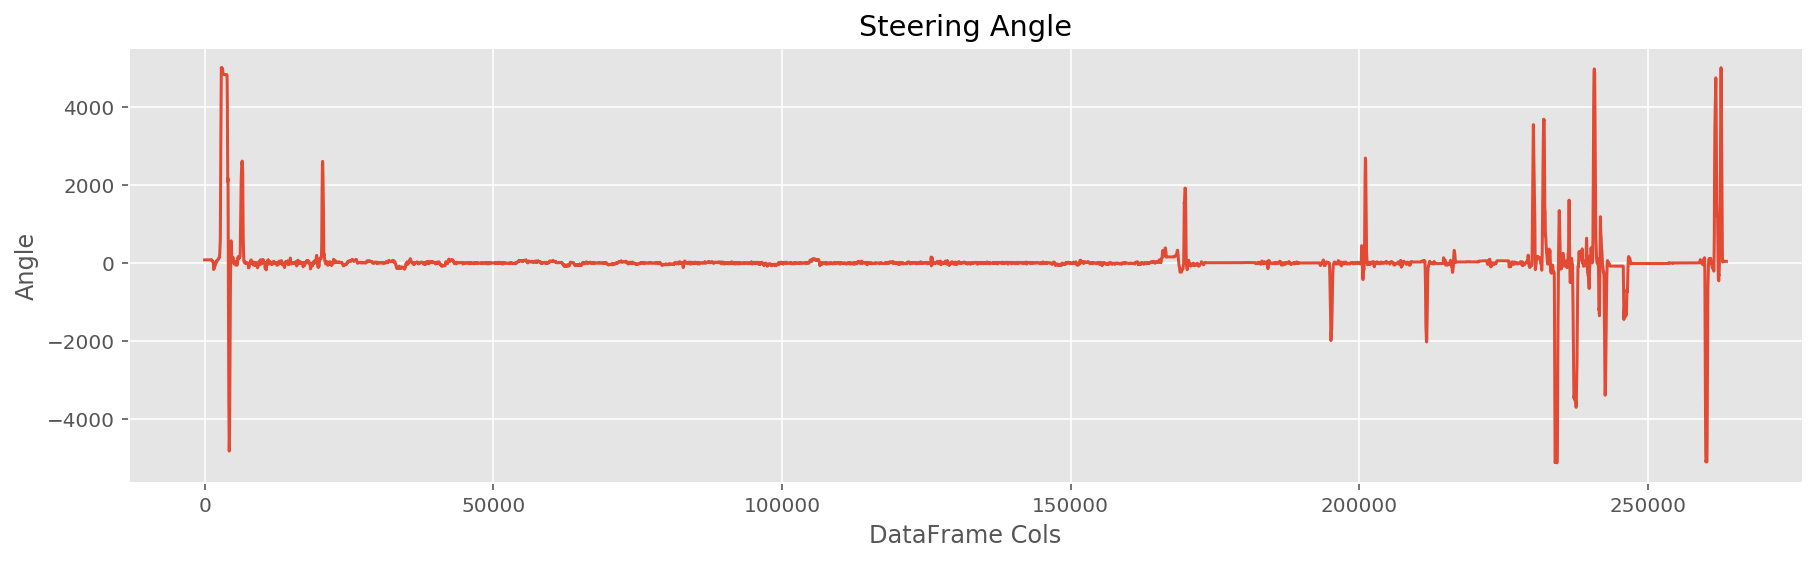

In [486]:
rcParams['figure.figsize'] = 15, 4
#CAN_downsampled[['cam_index','steering_angle']].plot(x='cam_index',y='steering_angle')
CAN_downsampled['steering_angle'].plot()

plt.xlabel('DataFrame Cols')
plt.ylabel('Angle')
plt.title('Steering Angle')

<strong> Regions with high steering angle values are generally associated to in-city roads and parking manouvers.
</strong> 

The following sequences of frames are retain for training:
      - frames [2300,17000]

Driveway sequence:

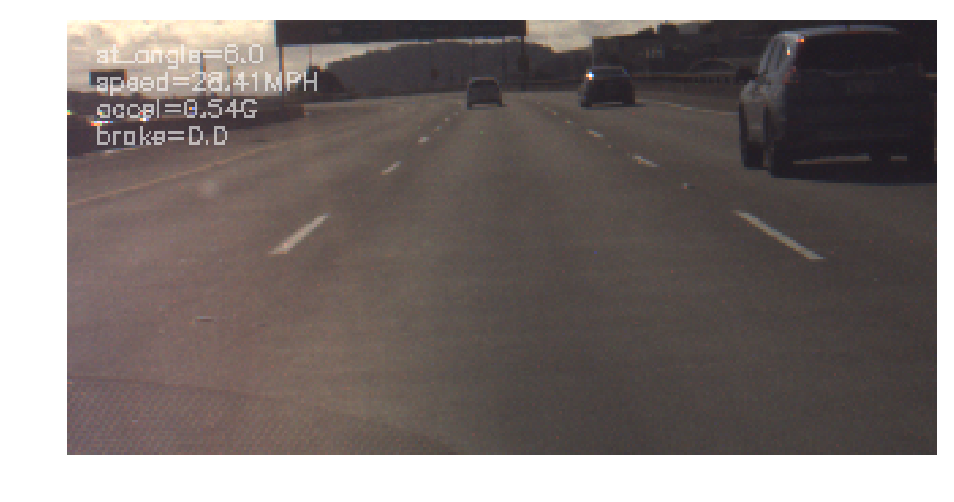

In [82]:
play_raw_data(CAN_downsampled, imgs, f_init=2300,f_end=2350)

In [116]:
training_df = CAN_downsampled.iloc[2300:16500]
training_df.head()

cam_index  steering_angle      speed     accel  brake  stop_flag
23000     4593.0       23.000000  26.022835  0.773637    0.0        1.0
23010     4595.0       19.827596  26.094446  0.601005    0.0        1.0
23020     4597.0       19.000000  26.173665  0.664587    0.0        1.0
23030     4599.0       19.000000  26.237341  0.698118    0.0        1.0
23040     4601.0       19.000000  26.321907  0.625089    0.0        1.0

In [117]:
training_df.describe()

cam_index  steering_angle         speed         accel         brake  \
count  14200.000000    14200.000000  14200.000000  14200.000000  14200.000000   
mean   18796.184014        0.711103     29.385366      0.003783     13.601333   
std     8201.032771       28.340412      2.664503      0.401071     74.750578   
min     4593.000000     -159.000000     17.039014     -2.161291    -48.000000   
25%    11694.500000       -9.000000     28.041074     -0.260321      0.000000   
50%    18796.000000        1.000000     29.793421     -0.001105      0.000000   
75%    25896.500000       12.000000     31.051886      0.247571      0.000000   
max    32999.000000      154.594853     35.829370      1.789565    892.594488   

       stop_flag  
count    14200.0  
mean         1.0  
std          0.0  
min          1.0  
25%          1.0  
50%          1.0  
75%          1.0  
max          1.0

<strong> Training dataset have only smooth between lanes highway driving. More training examples needs to be added!
</strong> 

In [500]:
# Get training set image indexes
train_index = training_df['cam_index'].values.astype(int)
train_X = imgs[train_index]
print('Training sequences shape = ', np.shape(train_X))

# Get target variable
train_Y = training_df['steering_angle'].values.astype(int)
print('Training target shape = ', np.shape(train_Y))

#np.save('train_X.npy',train_X)
#np.save('train_Y.npy',train_Y)

Training sequences shape =  (14200, 3, 160, 320)
Training target shape =  (14200,)


### Data Augmentation

Custom functions:
    - Horizontal flipping (valid for between lanes highway road)
    - Random horizontal inclination
    - Random intensity manipulation
    - Weather condition simulation using Automold

In [505]:
import skimage.exposure as sk
import scipy

def horizontal_flip(img, angle):
    """Horizontal image flipping and angle correction.
    
    angle.
    """    
    return np.fliplr(img), angle*-1


def horizontal_rotation(img,angle,vmin=-10,vmax=10):
    """Horizontal axis random rotations with Gaussian distribution. Corrects steering angle.
    
    """
    angle_rot = random.uniform(vmin,vmax)
    img_rotated = scipy.ndimage.rotate(img,angle_rot,reshape=False, mode='nearest')
    angle_rotated = angle - angle_rot
    
    return img_rotated, angle


def intensity_manipulation(img,angle,vmin=140,vmax=160):
    """Random intesity manipulation to
    simulate changes in light conditions. Angles are not corrected.
    
    """
    limit = random.uniform(vmin,vmax)
    low_limit = random.uniform(0,60)
    int_img = sk.rescale_intensity(img, in_range=(low_limit,limit), out_range='dtype')
    
    return int_img, angle


def random_shadow(image):
    
    top_y = 320*np.random.uniform()
    top_x = 0
    bot_x = 160
    bot_y = 320*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    #random_bright = .25+.7*np.random.uniform()
    if np.random.randint(2)==1:
        random_bright = .5
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright    
    image = cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)
    
    return image


Text(0.5,1,'Flipped')

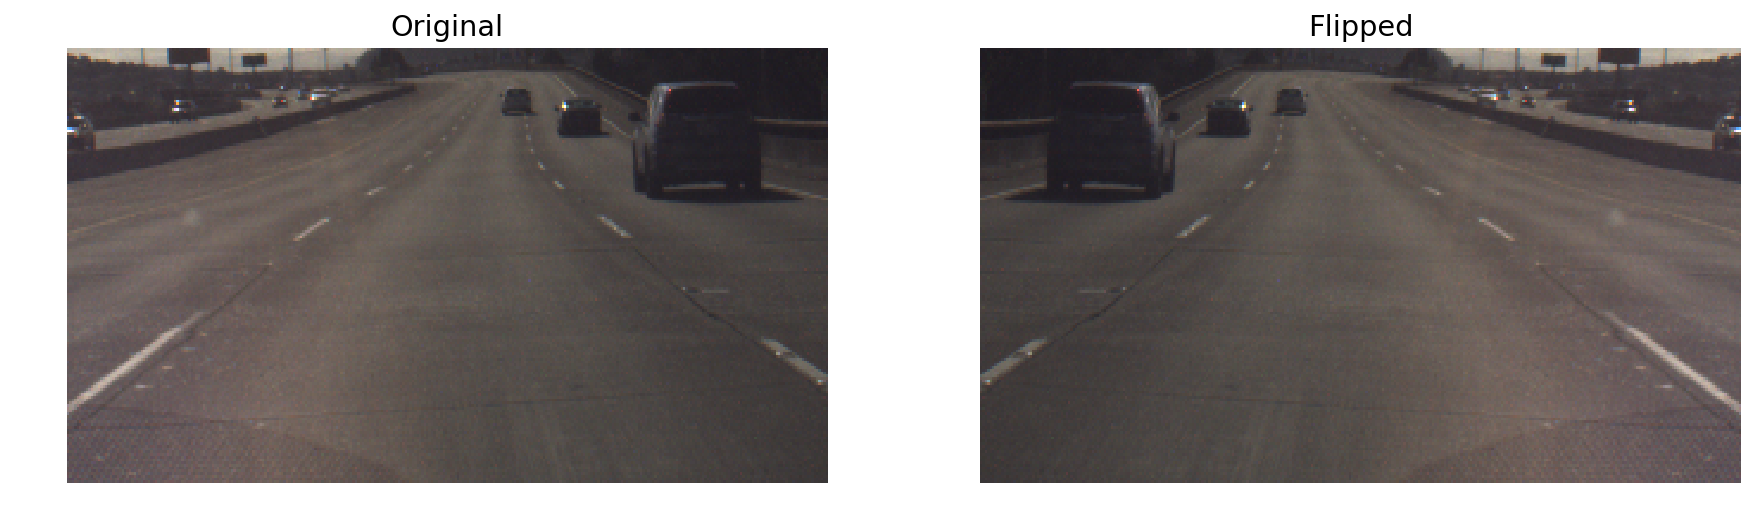

In [502]:
fig, ax = plt.subplots(1,2)
img = channel_last(train_X[0])
ax[0].imshow(img)
ax[0].axis('off')
ax[0].axis('tight')
ax[0].set_title('Original')
img = horizontal_flip(channel_last(train_X[0]),train_Y[0])[0]
ax[1].imshow(img)
ax[1].axis('off')
ax[1].axis('tight')
ax[1].set_title('Flipped')

Text(0.5,1,'Modified Intensity')

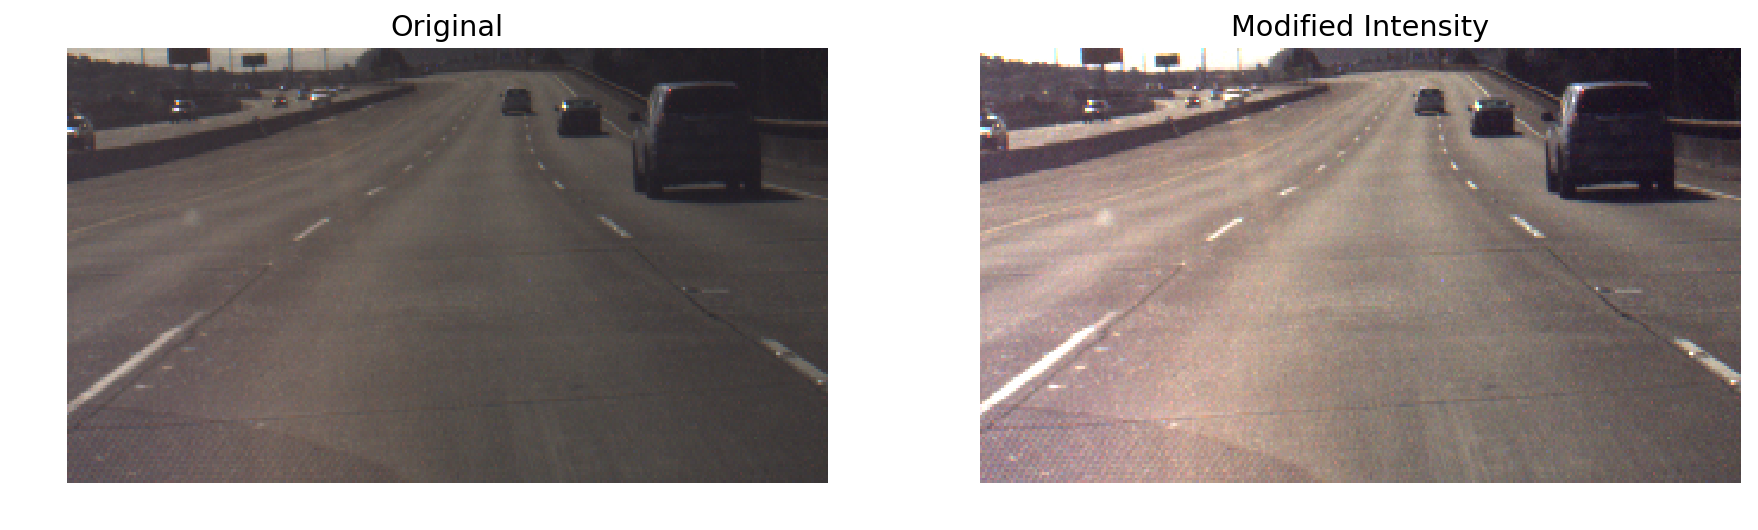

In [506]:
fig, ax = plt.subplots(1,2)
img = channel_last(train_X[0])
ax[0].imshow(img)
ax[0].axis('off')
ax[0].axis('tight')
ax[0].set_title('Original')
img = intensity_manipulation(channel_last(train_X[0]),train_Y[0])[0]
ax[1].imshow(img)
ax[1].axis('off')
ax[1].axis('tight')
ax[1].set_title('Modified Intensity')

Text(0.5,1,'Random rotation')

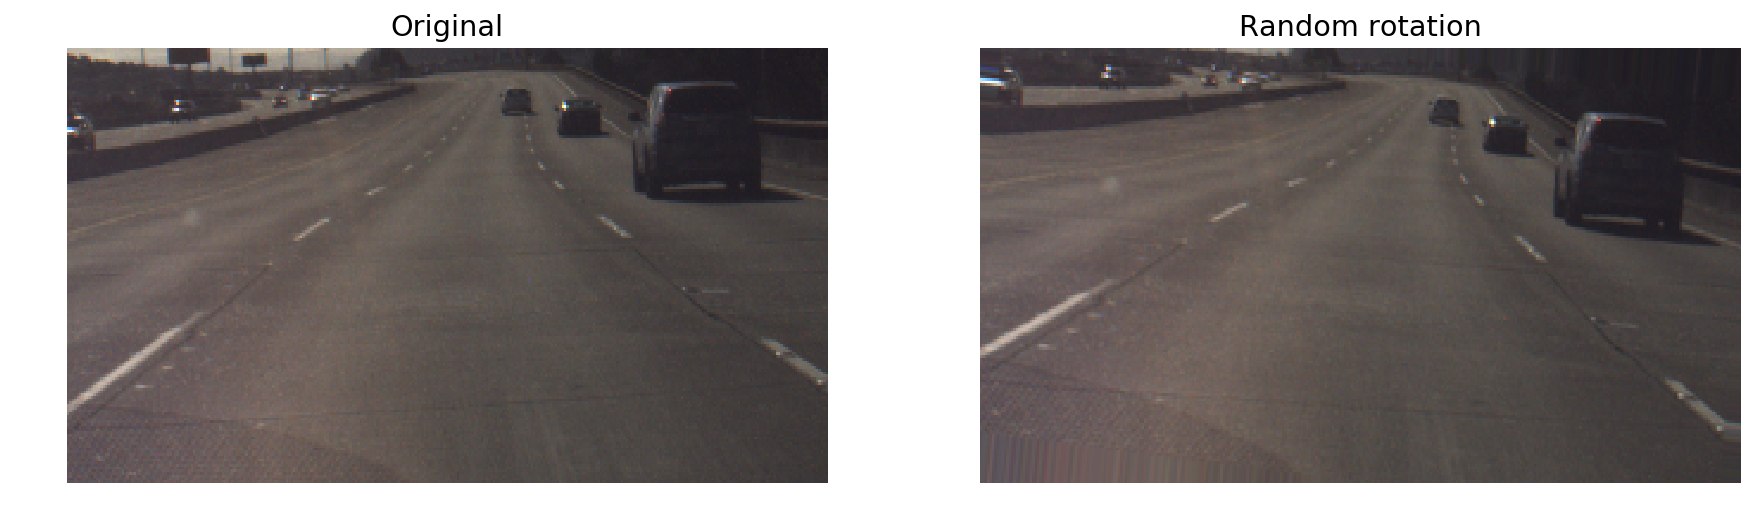

In [507]:
fig, ax = plt.subplots(1,2)
img = channel_last(train_X[0])
ax[0].imshow(img)
ax[0].axis('off')
ax[0].axis('tight')
ax[0].set_title('Original')
img = horizontal_rotation(channel_last(train_X[0]),train_Y[0])[0]
ax[1].imshow(img)
ax[1].axis('off')
ax[1].axis('tight')
ax[1].set_title('Random rotation')

Text(0.5,1,'Random shadow')

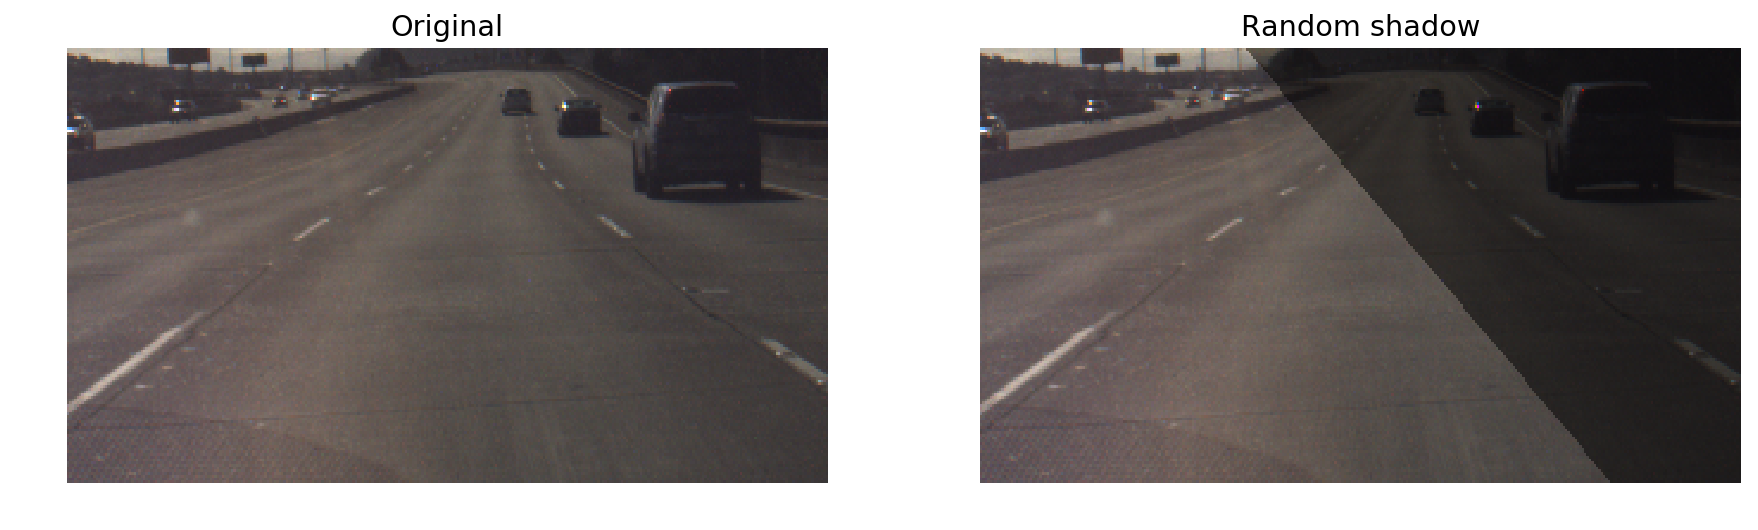

In [508]:
fig, ax = plt.subplots(1,2)
img = channel_last(train_X[0])
ax[0].imshow(img)
ax[0].axis('off')
ax[0].axis('tight')
ax[0].set_title('Original')
img = random_shadow(channel_last(train_X[0]))
ax[1].imshow(img)
ax[1].axis('off')
ax[1].axis('tight')
ax[1].set_title('Random shadow')

### 3) Average-per-channel Normalization

- Option 1: VGG-Like image normalization by finding the mean of RGB channels accross the whole dataset. 

- Option 2: Batch normalisation on non-normalized images.

In [308]:
# Extract Red, Green and Blue channels
red = [x[0,:,:] for x in train_X]
green = [x[1,:,:] for x in train_X]
blue = [x[2,:,:] for x in train_X]

# [0, 1] Normalisation
red = np.array(red)/255
green = np.array(green)/255
blue = np.array(blue)/255

# Compute mean and STD
red_mean = np.mean(red)
green_mean = np.mean(green)
blue_mean = np.mean(blue)

red_std = np.std(red)
green_std = np.std(green)
blue_std = np.std(blue)

print('Mean channel 1 = ', red_mean)
print('Mean channel 2 = ', green_mean)
print('Mean channel 3 = ', blue_mean)

print('Std channel 1 = ', red_std)
print('Std channel 2 = ', green_std)
print('Std channel 3 = ', blue_std)

Mean channel 1 =  0.2836015941351274
Mean channel 2 =  0.25615464195405396
Mean channel 3 =  0.2644761364803414
Std channel 1 =  0.13447942192035023
Std channel 2 =  0.1201946284858539
Std channel 3 =  0.10585553265973169


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


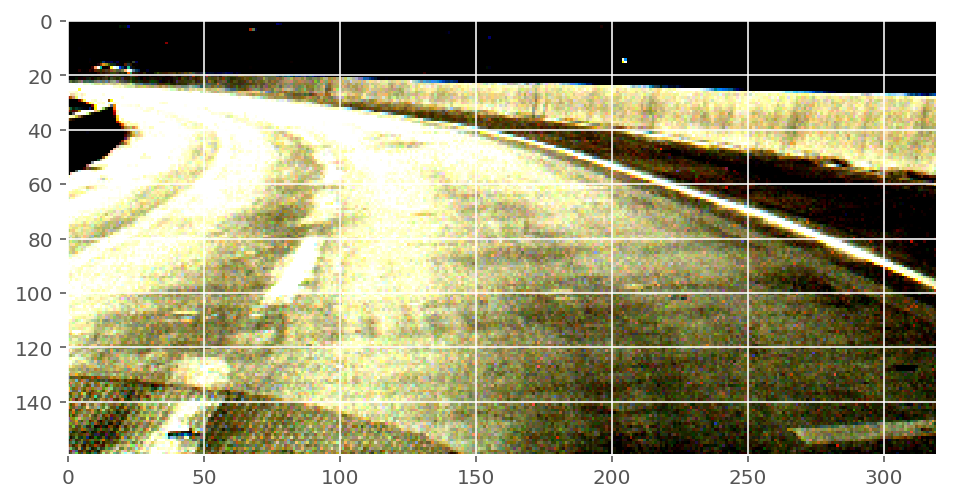

In [509]:
# Final values
mean = [0.283, 0.256, 0.264 ]
std = [0.134, 0.120, 0.105 ]

def normalize(img, mean=[0.283, 0.256, 0.264 ], std=[0.134, 0.120, 0.105]):
    '''Normalize image and returns RGB format.
    '''
    img = img/255
    red = (img[0,:,:] - mean[0]) / std[0]
    green = (img[1,:,:] - mean[1]) / std[1]
    blue = (img[2,:,:] - mean[2]) / std[2]

    return np.dstack((red,green,blue))

im = train_X[1110]

plt.imshow(normalize(im))

### 5) Equilibrate the dataset to avoid biases
    - Evaluate the proportion between curves and straight sequences.
    - Perform Data Augmentation on sparse 'curves' sequences.
   

Text(0,0.5,'Angle')

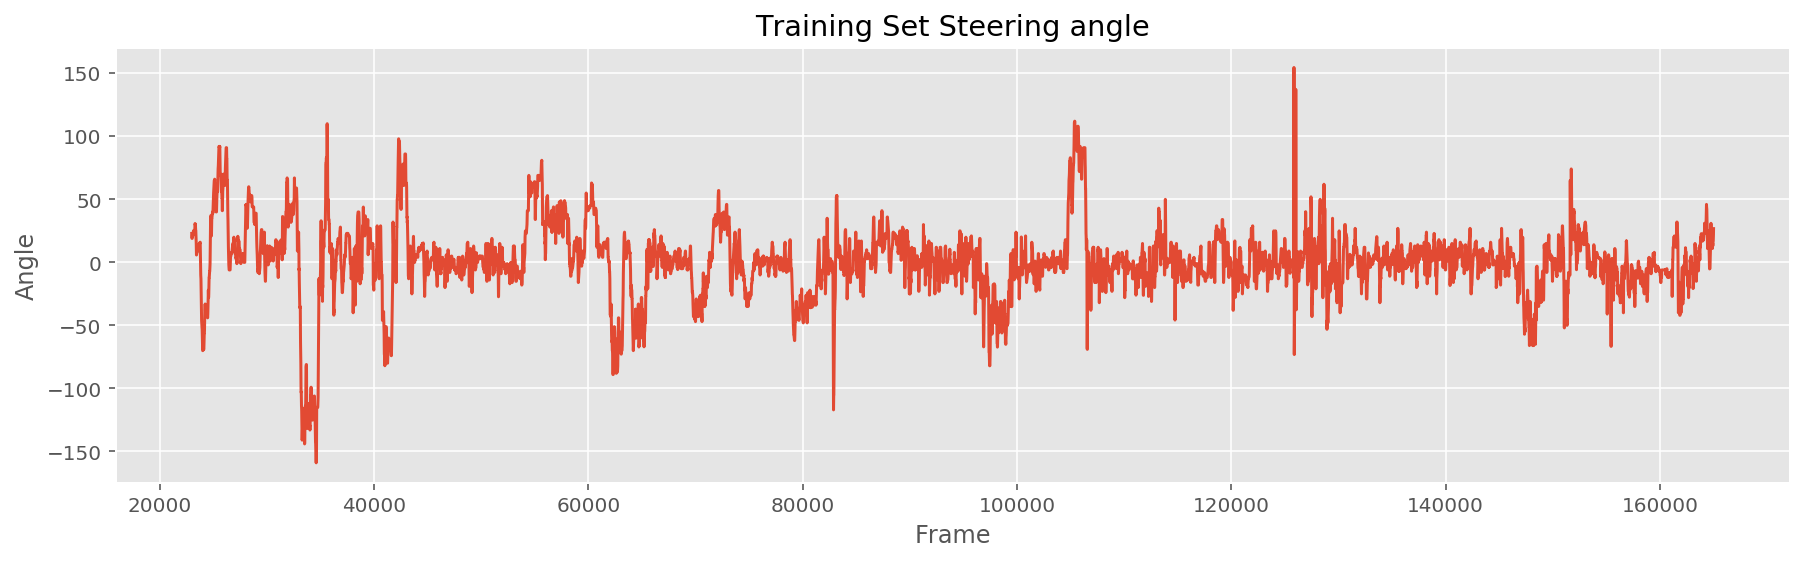

In [375]:
training_df.steering_angle.plot()
plt.title('Training Set Steering angle')
plt.xlabel('Frame')
plt.ylabel('Angle')

Text(0.5,1,'Steering angle histogram')

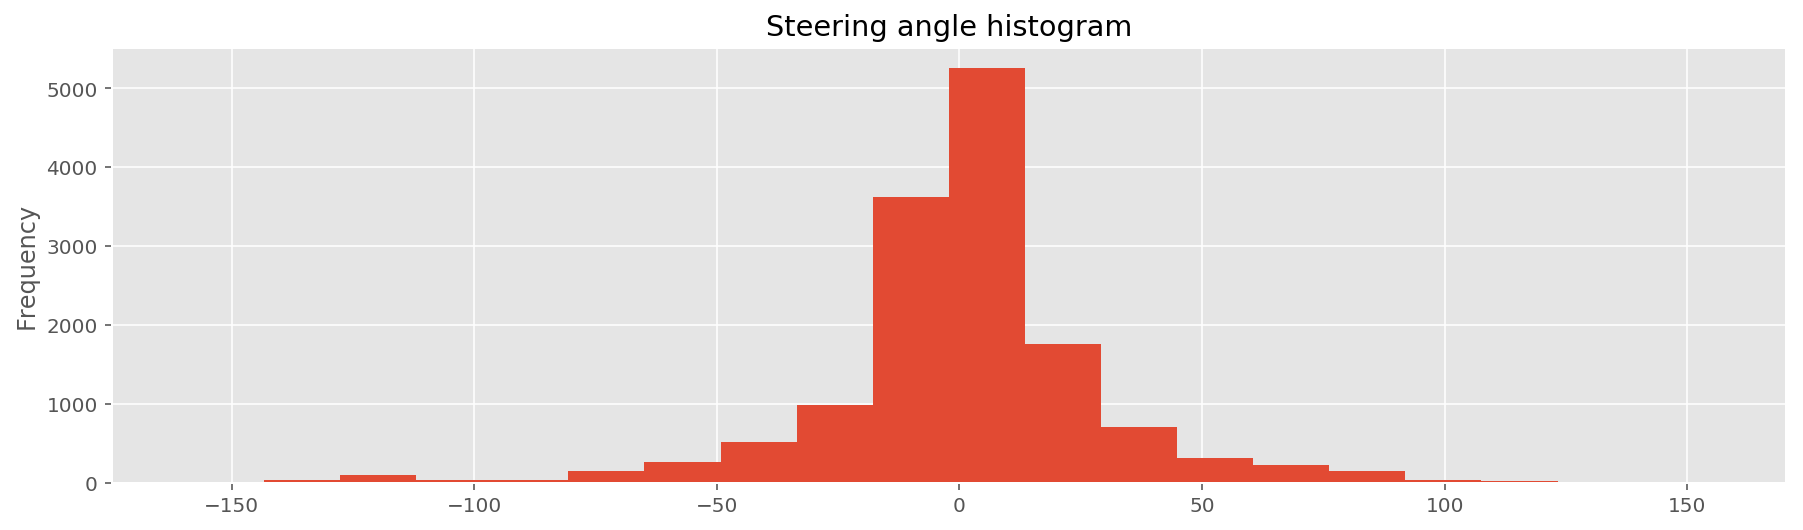

In [379]:
training_df.steering_angle.plot.hist(bins=20)
plt.title('Steering angle histogram')

In [381]:
training_df.steering_angle.describe()

count    14200.000000
mean         0.711103
std         28.340412
min       -159.000000
25%         -9.000000
50%          1.000000
75%         12.000000
max        154.594853
Name: steering_angle, dtype: float64

### Extract sequences with curves:  Mean +/- Std

In [390]:
# Pandas conditional selection
curves_df_left = training_df[training_df.steering_angle.values < (0.7 - 30)] 
curves_df_right = training_df[training_df.steering_angle.values > (0.7 + 30)]

In [391]:
curves_df_left.describe()

cam_index  steering_angle        speed        accel        brake  \
count   1316.000000     1316.000000  1316.000000  1316.000000  1316.000000   
mean   15528.320669      -56.961269    29.532317    -0.002364    14.996629   
std     7459.779842       27.651664     2.161431     0.413943    78.966032   
min     4771.000000     -159.000000    20.480824    -2.161291   -32.000000   
25%     8291.500000      -66.000000    28.414287    -0.230051     0.000000   
50%    14107.000000      -47.968068    30.305889     0.004067     0.000000   
75%    19654.500000      -37.000000    31.038928     0.213883     0.000000   
max    32425.000000      -29.389378    32.170970     1.431862   880.000000   

       stop_flag  
count     1316.0  
mean         1.0  
std          0.0  
min          1.0  
25%          1.0  
50%          1.0  
75%          1.0  
max          1.0

In [392]:
curves_df_right.describe()

cam_index  steering_angle        speed        accel        brake  \
count   1369.000000     1369.000000  1369.000000  1369.000000  1369.000000   
mean   12309.378378       53.100198    29.871652     0.035049     2.098339   
std     6630.918271       19.338352     2.167187     0.336349    22.853455   
min     4655.000000       30.837177    22.201506    -0.946848   -12.271271   
25%     6518.000000       38.000000    28.580279    -0.177115     0.000000   
50%    11207.000000       46.000000    29.762535     0.019929     0.000000   
75%    14520.000000       65.000000    31.083893     0.226478     0.000000   
max    32951.000000      154.594853    34.830667     1.778360   316.489190   

       stop_flag  
count     1369.0  
mean         1.0  
std          0.0  
min          1.0  
25%          1.0  
50%          1.0  
75%          1.0  
max          1.0

#### From a total count of 14200 training frames only 2700 are curves, that represents around 19%. To balance the dataset is necessary either to downsample the straight sequences or upsample the curves.


### Data Augmentation on sequences with curves by a factor of 4x

In [510]:
# Get left frames
left_index = curves_df_left['cam_index'].values.astype(int)
left_X = imgs[left_index]
print('Training left sequences shape = ', np.shape(left_X))

# Get target variable
left_Y = curves_df_left['steering_angle'].values.astype(int)
print('Training target shape = ', np.shape(left_Y))

# Get Right frames
right_index = curves_df_right['cam_index'].values.astype(int)
right_X = imgs[right_index]
print('Training right sequences shape = ', np.shape(right_X))

# Get target variable
right_Y = curves_df_right['steering_angle'].values.astype(int)
print('Training target shape = ', np.shape(right_Y))


Training left sequences shape =  (1316, 3, 160, 320)
Training target shape =  (1316,)
Training right sequences shape =  (1369, 3, 160, 320)
Training target shape =  (1369,)


In [511]:
# Left frames
aug1_left_X = []
aug1_left_Y = []

aug2_left_X = []
aug2_left_Y = []

aug3_left_X = []
aug3_left_Y = []

for index, frame in enumerate(left_X):
    
    im = random_shadow(channel_last(frame))
    aug1_left_X.append(im)
    aug1_left_Y.append(left_Y[index])
    
    im, target = horizontal_flip(channel_last(frame), left_Y[index])
    aug2_left_X.append(im)
    aug2_left_Y.append(target)
    
    
    im, target = intensity_manipulation(channel_last(frame), left_Y[index])
    aug3_left_X.append(im)
    aug3_left_Y.append(target)

left_X_RGB = [channel_last(x) for x in left_X]

left_X_aug = np.concatenate((aug1_left_X, aug2_left_X, aug3_left_X))
left_Y_aug = np.concatenate((aug1_left_Y, aug2_left_Y, aug3_left_Y))

print('Augmented left training samples = ', left_X_aug.shape[0])
print('Augmented left training targets = ', left_Y_aug.shape[0])

Augmented left training samples =  3948
Augmented left training targets =  3948


In [512]:
# Left frames
aug1_right_X = []
aug1_right_Y = []

aug2_right_X = []
aug2_right_Y = []

aug3_right_X = []
aug3_right_Y = []

for index, frame in enumerate(right_X):
    
    im = random_shadow(channel_last(frame))
    aug1_right_X.append(im)
    aug1_right_Y.append(right_Y[index])
    
    im, target = horizontal_flip(channel_last(frame), right_Y[index])
    aug2_right_X.append(im)
    aug2_right_Y.append(target)
    
    im, target = intensity_manipulation(channel_last(frame), right_Y[index])
    aug3_right_X.append(im)
    aug3_right_Y.append(target)

right_X_RGB = [channel_last(x) for x in right_X]
right_X_aug = np.concatenate((aug1_right_X, aug2_right_X, aug3_right_X))
right_Y_aug = np.concatenate((aug1_right_Y, aug2_right_Y, aug3_right_Y))

print('Augmented left training samples = ', right_X_aug.shape[0])
print('Augmented left training targets = ', right_Y_aug.shape[0])

Augmented left training samples =  4107
Augmented left training targets =  4107


(-0.5, 319.5, 159.5, -0.5)

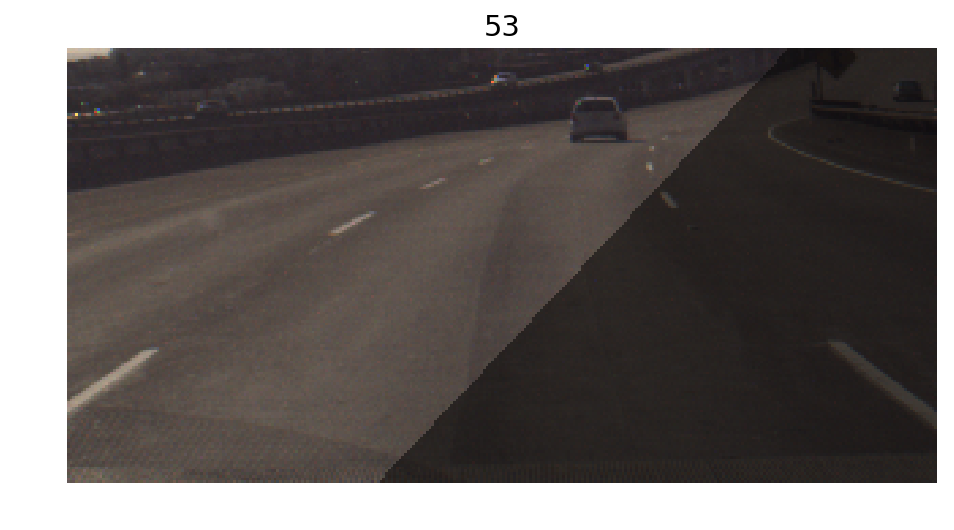

In [520]:
plt.imshow(right_X_aug[100])
plt.title('{}'.format(right_Y_aug[100]))
plt.axis('off')

(-0.5, 319.5, 159.5, -0.5)

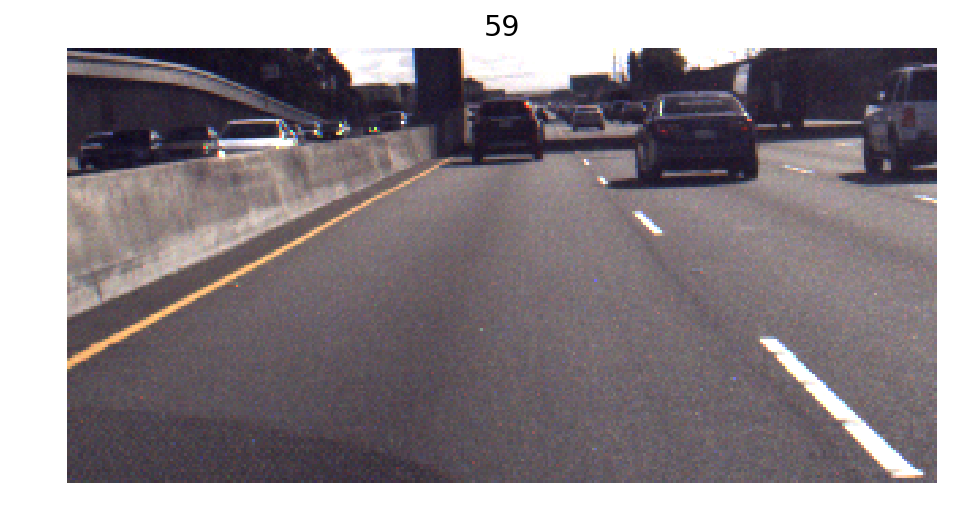

In [521]:
plt.imshow(right_X_aug[4000])
plt.title('{}'.format(right_Y_aug[4000]))
plt.axis('off')

#### Problem: Vehicle changing of lanes !  As these frames are scarse, probably won't present any problem.

In [523]:
# Saving augmented data

aug_X = np.concatenate((right_X_aug, left_X_aug)) # numpy array of images (already saved to disc)
aug_Y = np.concatenate((right_Y_aug, left_Y_aug))

np.save('augmented_final_X_RGB.npy',aug_X)
np.save('augmented_final_Y_RGB.npy',aug_Y)

df_aug = pd.DataFrame(aug_Y) # Pandas Dataframe

# Convert to Pandas Data frames
df_aug.columns = ['steering_angle']
df_aug['cam_index'] = df_aug.index
final = pd.concat((training_df[['steering_angle','cam_index']], df_aug))

#final.to_csv('augmented_df.csv')

Text(0.5,1,'Steering angle histogram before augmentation')

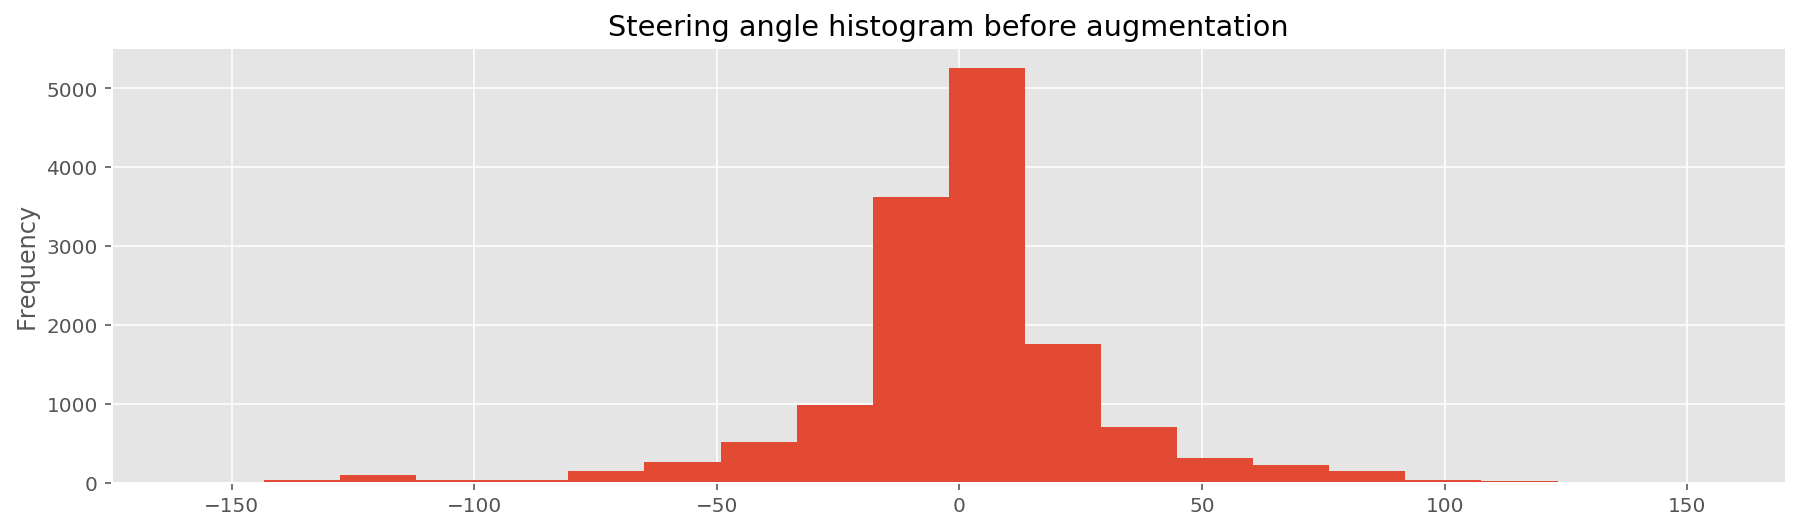

In [473]:
training_df.steering_angle.plot.hist(bins=20)
plt.title('Steering angle histogram before augmentation')

Text(0.5,1,'Steering angle histogram after augmentation')

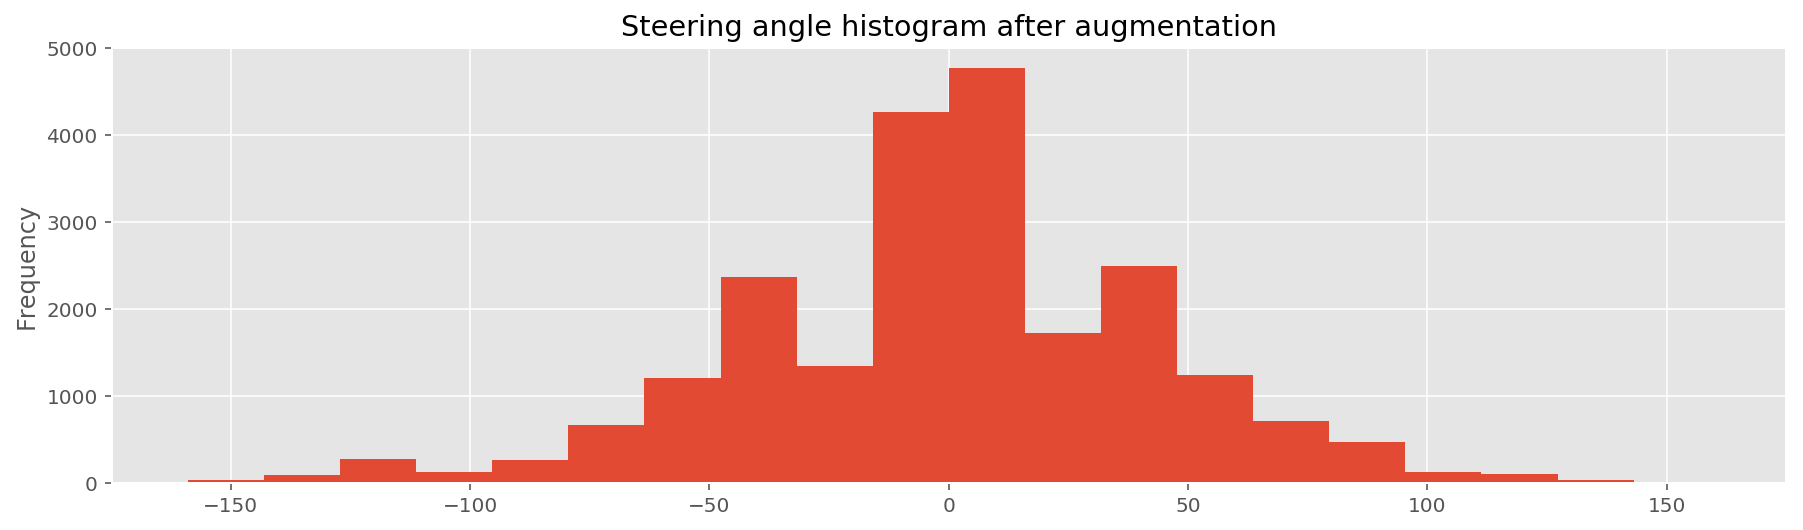

In [474]:
final.steering_angle.plot.hist(bins=20)
plt.title('Steering angle histogram after augmentation')

- The histogram with augmented images is more balanced.
- Possible additional work needed.

### 6) Normalize target variable to (1/R)

    - According several authors the inverse turning radius uˆ (= r−1, where r is the turning radius), which depends on the vehicle’s steering geometry and also result in numerical instability when predicting near zero steering angle commands. The relationship between the inverse turning radius ut and the steering angle com- mand θt can be approximated by Ackermann steering ge- ometry [20] as follows:
                            θt = fsteers(ut) = utdwKs(1 + Kslipvt2) (1)
    where θt in degrees and vt (m/s) is a steering angle and a velocity at time t, respectively. Ks , Kslip , and dw are vehicle-specific parameters. Ks is a steering ratio between the turn of the steering and the turn of the wheels. Kslip rep- resents the relative motion between a wheel and the surface of road. dw is the length between the front and rear wheels.

    - Without any information about car's geometry we're gonna use [-1, 1] normalization.


Text(0.5,1,'Histogram after steering angle normalization')

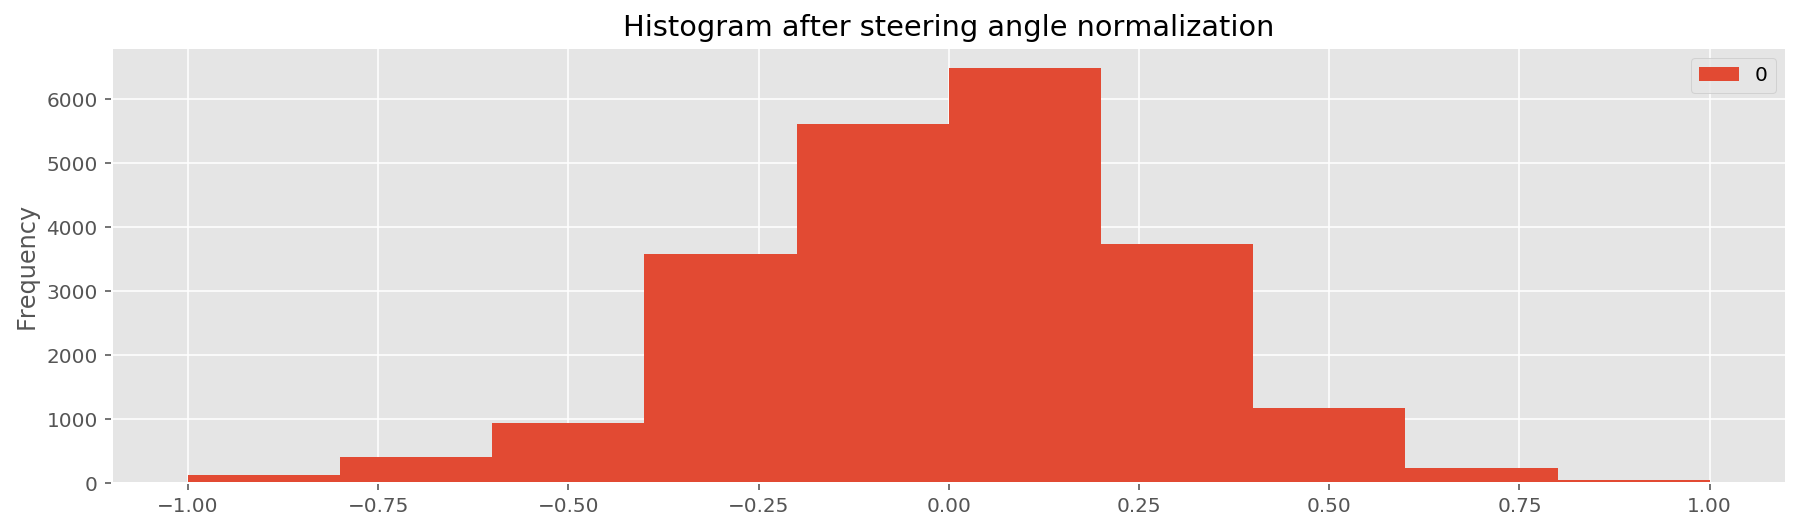

In [527]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler((-1,1))
df_norm = scaler.fit_transform(final.steering_angle.values.reshape(-1,1))
pd.DataFrame(df_norm).plot.hist()
plt.title('Histogram after steering angle normalization')